## fama_french因子模型
* 数据采用yfinance获得1982-2020的十个美股数据 from"S&P500"
* 使用fama-french中的无风险因子获得超额收益
* 分别生成通过 0,1,2,5的fama-french因子模型回归得到的残值时间序列，保存为csv文件
* 绘制残差图观察结果是否正常

In [235]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import logging
import os

In [236]:
# 选择股票列表
tickers = ['AAPL', 'SEE', 'AFL','LOW','RRC','WMT','NKE','PGR','FL','VMC']
data = yf.download(tickers, start="1982-01-01", end="2021-01-01")
data

[*********************100%***********************]  10 of 10 completed


Price                       Adj Close                                     
Ticker                           AAPL        AFL         FL         LOW   
Date                                                                      
1982-01-04 00:00:00+00:00    0.075713   0.047845   1.424582    0.238046  \
1982-01-05 00:00:00+00:00    0.071842   0.047073   1.453855    0.238046   
1982-01-06 00:00:00+00:00    0.070981   0.047073   1.453855    0.231112   
1982-01-07 00:00:00+00:00    0.065388   0.047073   1.444097    0.238046   
1982-01-08 00:00:00+00:00    0.068400   0.047845   1.453855    0.231112   
...                               ...        ...        ...         ...   
2020-12-24 00:00:00+00:00  129.189514  40.064209  35.007797  152.076294   
2020-12-28 00:00:00+00:00  133.810028  40.137310  35.779049  151.394272   
2020-12-29 00:00:00+00:00  132.028412  39.981960  35.752457  149.992767   
2020-12-30 00:00:00+00:00  130.902603  40.219559  35.885429  150.011475   
2020-12-31 00:00:00+00:00  129.894318  40.639942  35.849964  149.964767   

Price                                                                    
Ticker                            NKE        PGR        RRC        SEE   
Date                                                                     
1982-01-04 00:00:00+00:00    0.156136   0.089967  15.350168   0.298289  \
1982-01-05 00:00:00+00:00    0.151991   0.085122  14.253732   0.298289   
1982-01-06 00:00:00+00:00    0.149228   0.082354  14.253732   0.298289   
1982-01-07 00:00:00+00:00    0.150610   0.082354  14.253732   0.299645   
1982-01-08 00:00:00+00:00    0.157518   0.081662  14.253732   0.302357   
...                               ...        ...        ...        ...   
2020-12-24 00:00:00+00:00  135.648590  90.941307   6.880025  43.445679   
2020-12-28 00:00:00+00:00  136.443726  90.765526   6.361331  42.908493   
2020-12-29 00:00:00+00:00  135.619873  90.367775   6.106879  42.672894   
2020-12-30 00:00:00+00:00  135.629440  90.108765   6.557065  43.247768   
2020-12-31 00:00:00+00:00  135.524094  91.468567   6.557065  43.153522   

Price                                             ...     Volume            
Ticker                            VMC        WMT  ...       AAPL      AFL   
Date                                              ...                       
1982-01-04 00:00:00+00:00    2.250332   0.064854  ...   71254400   799920  \
1982-01-05 00:00:00+00:00    2.255517   0.062946  ...   35840000   665280   
1982-01-06 00:00:00+00:00    2.250332   0.060466  ...   66080000   269280   
1982-01-07 00:00:00+00:00    2.239961   0.060657  ...   70044800   459360   
1982-01-08 00:00:00+00:00    2.239961   0.062183  ...   56604800   316800   
...                               ...        ...  ...        ...      ...   
2020-12-24 00:00:00+00:00  138.828522  45.218620  ...   54930100  1383500   
2020-12-28 00:00:00+00:00  141.688019  45.760612  ...  124486200  2282700   
2020-12-29 00:00:00+00:00  138.392288  45.470699  ...  121047300  2386700   
2020-12-30 00:00:00+00:00  141.978836  45.432896  ...   96452100  1954500   
2020-12-31 00:00:00+00:00  143.762421  45.423443  ...   99116600  2159000   

Price                                                                    
Ticker                          FL      LOW      NKE      PGR      RRC   
Date                                                                     
1982-01-04 00:00:00+00:00    85600   310400  4531200    18225     1620  \
1982-01-05 00:00:00+00:00   301600   160000  2777600   929475      260   
1982-01-06 00:00:00+00:00   119200  1020800  3212800   874800      320   
1982-01-07 00:00:00+00:00   110400   182400  5606400  2916000      400   
1982-01-08 00:00:00+00:00   143600   912000  3955200  3152925     1110   
...                            ...      ...      ...      ...      ...   
2020-12-24 00:00:00+00:00   676200  1044600  1821900   724700  1875500   
2020-12-28 00:00:00+00:00  1460900  2635000  4081500  1338800  7519800   
2020-12-29 00:00:00

In [237]:
# 获取收盘价
close_prices = data['Adj Close']
# 计算每日收益
daily_returns = close_prices.pct_change().dropna()
# 格式化日期
daily_returns.index = daily_returns.index.strftime('%Y%m%d').astype(int)
dailydates=daily_returns.index
daily_returns_np = daily_returns.to_numpy()
daily_returns

Ticker,AAPL,AFL,FL,LOW,NKE,PGR,RRC,SEE,VMC,WMT
Date,,,,,,,,,,
19820105,-0.051133,-0.016136,0.020548,0.000000,-0.026547,-0.053846,-0.071428,0.000000,0.002304,-0.029410
19820106,-0.011976,0.000000,0.000000,-0.029127,-0.018180,-0.032520,0.000000,0.000000,-0.002299,-0.039397
19820107,-0.078794,0.000000,-0.006711,0.030001,0.009258,0.000000,0.000000,0.004545,-0.004608,0.003159
19820108,0.046062,0.016400,0.006757,-0.029127,0.045869,-0.008399,0.000000,0.009049,0.000000,0.025156
19820111,-0.062900,-0.016136,-0.006711,0.000000,0.008772,0.000000,-0.076923,-0.031390,0.000000,-0.015341
...,...,...,...,...,...,...,...,...,...,...
20201224,0.007712,0.007122,-0.015457,0.002093,-0.001129,0.008204,-0.044837,-0.003028,0.003574,0.001955
20201228,0.035765,0.001825,0.022031,-0.004485,0.005862,-0.001933,-0.075391,-0.012365,0.020597,0.011986
20201229,-0.013315,-0.003870,-0.000743,-0.009257,-0.006038,-0.004382,-0.040000,-0.005491,-0.023260,-0.006335


In [238]:
# 下载Fama-French五因子数据
ff_daily = pd.read_csv("https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_daily_CSV.zip", skiprows=3)
ff_daily=ff_daily.rename(columns={'Unnamed: 0':'Date'})
# ff_daily = ff_daily.iloc[:-1] #去除最后一行 #处理factor3链接时需要
ff_daily['Date'] = ff_daily['Date'].astype(int)
ff_daily_np = ff_daily.to_numpy() #转成数组方便处理
ffdailydates = ff_daily_np[:,0]#取出日期
ff_daily

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF
0,19630701,-0.67,0.02,-0.35,0.03,0.13,0.012
1,19630702,0.79,-0.28,0.28,-0.08,-0.21,0.012
2,19630703,0.63,-0.18,-0.10,0.13,-0.25,0.012
3,19630705,0.40,0.09,-0.28,0.07,-0.30,0.012
4,19630708,-0.63,0.07,-0.20,-0.27,0.06,0.012
...,...,...,...,...,...,...,...
15370,20240725,-0.30,1.67,0.67,-0.11,0.14,0.021
15371,20240726,1.10,0.58,-0.19,0.02,0.09,0.021
15372,20240729,-0.02,-1.05,-0.44,0.61,-0.25,0.021
15373,20240730,-0.50,0.69,1.37,0.46,-1.03,0.021


In [239]:
initialOOSyear = 2002
finalOOSyear = 2021
sizewindow = 60
T,N = daily_returns.shape
firstOOSDailyIdx = np.argmax(dailydates >= initialOOSyear*10000)
firstOOSFFDailyIdx = np.argmax(ffdailydates >= initialOOSyear*10000)
finalOOSFFDailyIdx = np.argmax(ffdailydates >= finalOOSyear*10000)
print(T,N,firstOOSDailyIdx,firstOOSFFDailyIdx,finalOOSFFDailyIdx)

9833 10 5049 9692 14476


In [250]:
#  无风险利率调整后的超额收益
RF = ff_daily['RF'].to_numpy()
sample_begin = 1982
sample_over = 2021
beginIdx = np.argmax(ffdailydates>=sample_begin*10000)
overIdx = np.argmax(ffdailydates>=sample_over*10000)
print(ff_daily['Date'][beginIdx+1],ff_daily['Date'][overIdx-1])
RF = RF[beginIdx+1:overIdx]
excess_returns = daily_returns.to_numpy()
for i in list(range(N)):
    excess_returns[:,i]=excess_returns[:,i]-RF/100
excess_returns_df = pd.DataFrame(excess_returns, index=daily_returns.index, columns=daily_returns.columns )
path=r'E:\dlsa'
filename = f"{path}\Excess_Returns_adjusted.csv"
excess_returns_df.to_csv(filename)
excess_returns_df

19820105 20201231


Ticker,AAPL,AFL,FL,LOW,NKE,PGR,RRC,SEE,VMC,WMT
Date,,,,,,,,,,
19820105,-0.051533,-0.016536,0.020148,-0.000400,-0.026947,-0.054246,-0.071828,-0.000400,0.001904,-0.029810
19820106,-0.012376,-0.000400,-0.000400,-0.029527,-0.018580,-0.032920,-0.000400,-0.000400,-0.002699,-0.039797
19820107,-0.079194,-0.000400,-0.007111,0.029601,0.008858,-0.000400,-0.000400,0.004145,-0.005008,0.002759
19820108,0.045662,0.016000,0.006357,-0.029527,0.045469,-0.008799,-0.000400,0.008649,-0.000400,0.024756
19820111,-0.063300,-0.016536,-0.007111,-0.000400,0.008372,-0.000400,-0.077323,-0.031790,-0.000400,-0.015741
...,...,...,...,...,...,...,...,...,...,...
20201224,0.007712,0.007122,-0.015457,0.002093,-0.001129,0.008204,-0.044837,-0.003028,0.003574,0.001955
20201228,0.035765,0.001825,0.022031,-0.004485,0.005862,-0.001933,-0.075391,-0.012365,0.020597,0.011986
20201229,-0.013315,-0.003870,-0.000743,-0.009257,-0.006038,-0.004382,-0.040000,-0.005491,-0.023260,-0.006335


In [241]:
ff_modified_np = np.delete(ff_daily_np,[0,-1],axis=1) #仅留下有用的五因子
ff_modified_np

array([[-0.67,  0.02, -0.35,  0.03,  0.13],
       [ 0.79, -0.28,  0.28, -0.08, -0.21],
       [ 0.63, -0.18, -0.1 ,  0.13, -0.25],
       ...,
       [-0.02, -1.05, -0.44,  0.61, -0.25],
       [-0.5 ,  0.69,  1.37,  0.46, -1.03],
       [ 1.52, -0.97, -1.32,  0.44,  1.43]])

In [242]:
daily_returns.index[firstOOSDailyIdx:]

Index([20020102, 20020103, 20020104, 20020107, 20020108, 20020109, 20020110,
       20020111, 20020114, 20020115,
       ...
       20201217, 20201218, 20201221, 20201222, 20201223, 20201224, 20201228,
       20201229, 20201230, 20201231],
      dtype='int32', name='Date', length=4784)

In [253]:
Rdaily = excess_returns.copy()
OOSdailydates = dailydates[firstOOSDailyIdx:]
idxsSelected = np.ones(N)
listFactors = [0,1,3,5]
for factor in listFactors:
    residualsOOS = np.zeros((T-firstOOSDailyIdx,N), dtype=float)  #存储残差
    residualsMatricesOOS = np.zeros((T-firstOOSDailyIdx,N,N+factor), dtype=np.float32)  #存储回归系数等信息
    
    for t in range(T - firstOOSDailyIdx):
        if factor == 0:  #没有因子模型的情况下，直接将原始的日收益率作为残差，
            residualsOOS[t:(t+1)] = Rdaily[(t+firstOOSDailyIdx):(t+firstOOSDailyIdx+1)]          
            residualsMatricesOOS[t:(t+1)] = np.diag(idxsSelected) #创建一个对角矩阵，用于标记哪些股票是被选中的。
        else:
            Y =  Rdaily[(t+firstOOSDailyIdx-sizewindow):(t+firstOOSDailyIdx)] #当前窗口内被选中的资产的日收益率数据，因变量 Y
            X =  ff_modified_np[(t+firstOOSFFDailyIdx-sizewindow):(t+firstOOSFFDailyIdx),:factor]#当前窗口内所选取的因子数据，自变量X  
            regr = LinearRegression(fit_intercept=False,n_jobs=48).fit(X,Y)
            loadings = regr.coef_.T #获取回归模型的系数，即因子载荷。这些系数表示每个资产对各个因子的敏感程度
            OOSreturns = Rdaily[(t+firstOOSDailyIdx):(t+firstOOSDailyIdx+1)] #提取当前时刻的资产收益率
            factors = ff_modified_np[(t+firstOOSFFDailyIdx):(t+firstOOSFFDailyIdx+1),:factor] #提取当前时刻的因子值
            
            #将因子值与因子载荷相乘，得到因子解释的部分，再从实际收益中减去，得到无法被因子解释的部分。
            residuals = OOSreturns - factors.dot(loadings)
            residualsOOS[t:(t+1)] = np.nan_to_num(residuals,copy=False)
            
            Loadings = -loadings.T #转置方便赋值给矩阵
            residualsMatricesOOS[t,:,:N] = np.diag(idxsSelected)
            residualsMatricesOOS[t,:,N:] = np.nan_to_num(Loadings, copy=False)
    np.nan_to_num(residualsOOS,copy=False)
    np.nan_to_num(residualsMatricesOOS,copy=False)
    logging.info(f"Finished!factor: {factor}")
    logging.info(f"Saving")
    residuals_df = pd.DataFrame(residualsOOS,index=daily_returns.index[firstOOSDailyIdx:],columns=daily_returns.columns)
    output_path = r'E:\dlsa\residuals'  # 指定保存文件的目录
    # 检查目录是否存在，不存在则创建
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    residuals_filename = f"{output_path}\_{factor}_factors_{initialOOSyear}_initialOOSyear.csv"
    residuals_df.to_csv(residuals_filename)  # 保存到指定路径

In [280]:
residuals_df.index[1000]

20051220

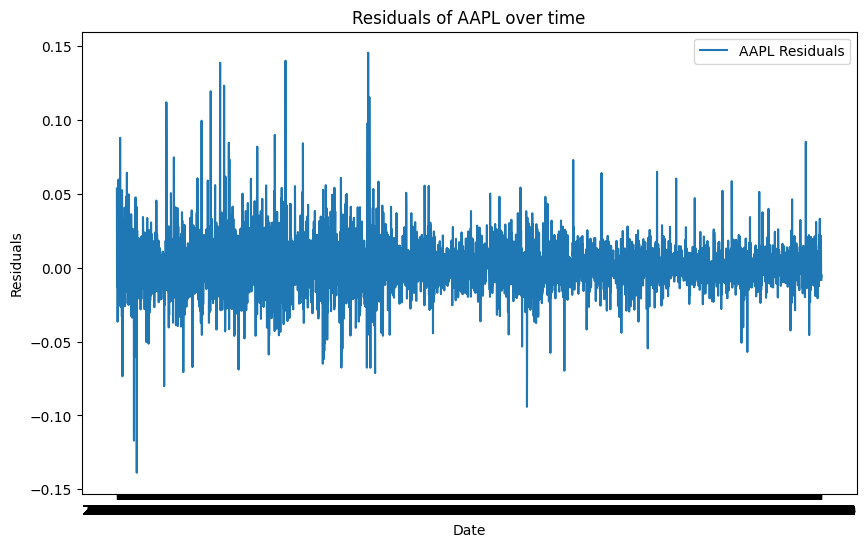

In [245]:
import matplotlib.pyplot as plt

# 绘制残差序列图
plt.figure(figsize=(10, 6))
plt.plot(residuals_df.index.astype(str), residuals_df['AAPL'], label='AAPL Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals of AAPL over time')
plt.legend()
plt.show()